<a href="https://colab.research.google.com/github/jessebuyungo/yield_prediction/blob/main/Ibuga_sentine%3Bl-%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install fusets

In [1]:
import fusets

In [ ]:
import ee
import geemap

In [2]:
import pandas as pd

In [3]:

data = pd.read_csv('Ibuga_s2.csv')
data.head()
data = data.rename(columns={'date': 'time'})

data

,NDVI,time
0,0.671468,2018-12-14
1,0.621787,2018-12-19
2,0.631176,2019-01-03
3,0.599654,2019-01-08
4,0.537606,2019-01-13
...,...,...
302,0.641785,2024-12-27
303,0.406556,2025-01-01
304,0.501548,2025-01-06
305,0.391596,2025-01-11


In [4]:
import numpy as np

In [5]:
numpy_dates    =  []
numpy_ndvi     =  []
easting        =  []
northing       =  []

for i in range(len(data)):
    east =np.array(4000)
    north = np.array(1000)
    m1= np.datetime64(data['time'][i])
    m2= np.array(data['NDVI'][i])
    numpy_dates.append(m1)
    numpy_ndvi.append(m2)
    easting.append(east)
    northing.append(north)

v1= np.array(1000)
v2= np.array(4000)





In [6]:
import xarray as xr

In [7]:
ndvi_xr = xr.DataArray(
    data=numpy_ndvi,
    coords={'time': numpy_dates,

            },
    dims=['time' ],


)




/tmp/ipython-input-2125767148.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ndvi_xr = xr.DataArray(


In [8]:
from fusets import WhittakerTransformer as Tr
transformer = Tr()

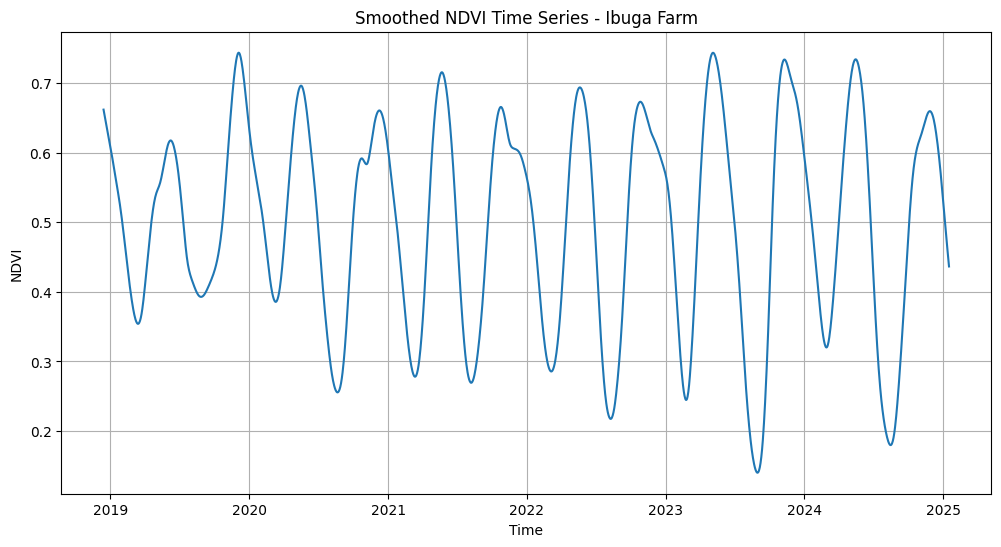

In [54]:
transformed_X = transformer.fit_transform(ndvi_xr,
                                          smoothing_lambda=5000,
                                          time_dimension = 'time',
                                          prediction_period='P1D')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import mdates

# Plot the transformed NDVI data. Ensure 'transformed_X' is defined in a previous cell.
plt.figure(figsize=(12, 6))
plt.plot(transformed_X['time'],np.array(transformed_X), label ='smothed ndvi')
plt.title('Smoothed NDVI Time Series - Ibuga Farm')


plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)


# Set the x-axis to show yearly markings
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

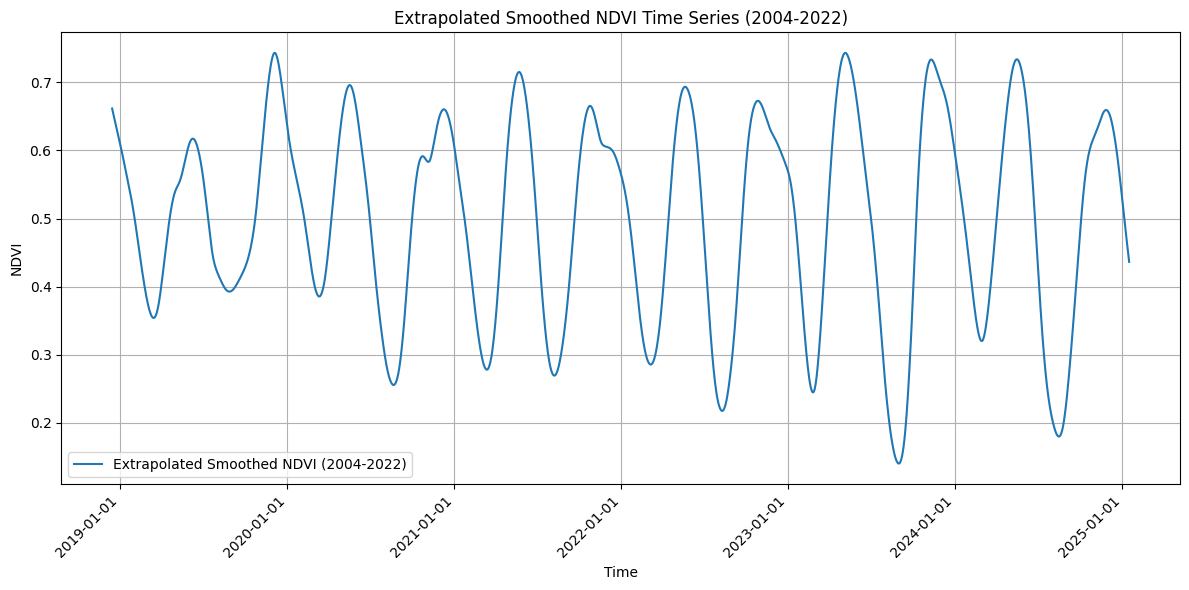

In [55]:
# Select data from 2004 to 2022
#extrapolated_X_subset = transformed_X.sel(time=slice('2002', '2024'))
extrapolated_X_subset = transformed_X

# Plot the subset of the extrapolated NDVI data
plt.figure(figsize=(12, 6))
extrapolated_X_subset.plot(label='Extrapolated Smoothed NDVI (2004-2022)')

plt.title('Extrapolated Smoothed NDVI Time Series (2004-2022)')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)

# Optional: Improve x-axis formatting for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # More detailed date format
plt.xticks(rotation=45, ha='right') # Rotate date labels for readability

plt.legend()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [56]:
len(transformed_X)

2226

Compute peaks

In [57]:
from fusets.analytics import phenology as ph
from fusets.peakvalley import peakvalley as pk
#result = ph(transformed_X)
#peaks = pk(extrapolated_X_subset,drop_thr=0.5, rec_r=0.25, slope_thr=-0.007)
peaks = pk(extrapolated_X_subset,drop_thr=0.13, rec_r=0.15, slope_thr=-0.007)


In [58]:
# Filter peaks where the NDVI value is equal to 0
peaks_at_zero_ndvi = peaks.where(peaks == -1, drop=True)
valley = peaks.where(peaks == 1, drop=True)

len(peaks_at_zero_ndvi)

12

In [59]:

dates_see = peaks_at_zero_ndvi['time']

#end of season defined
dates_valley = valley['time']



In [60]:
# Add an attribute 'period' with value 'SOS' to dates_valley
start = pd.DataFrame(dates_valley, columns=['time'])
start['period'] = 'EOS'


end= pd.DataFrame(dates_see, columns=['time'])
end['period'] = 'SOS'

all_marked_dates = pd.concat([start, end] )
#all_marked_dates.rename(columns={'': 'time'}, inplace=True)
all_marked_dates = all_marked_dates.sort_values(by='time')
all_marked_dates.head()




,time,period
0,2019-02-04,EOS
0,2019-03-15,SOS
1,2019-07-07,EOS
1,2019-08-28,SOS
2,2020-02-03,EOS


In [61]:
season_lengths = []
start_date = None

for index, row in all_marked_dates.iterrows():
    if row['period'] == 'SOS':
        start_date = row['time']
    elif row['period'] == 'EOS' and start_date is not None:
        end_date = row['time']
        season_length = end_date - start_date
        season_lengths.append({'start_date': start_date, 'end_date': end_date, 'length': season_length})
        start_date = None # Reset start_date after finding an EOS

season_lengths_df = pd.DataFrame(season_lengths)

print("Computed season lengths:")
display(season_lengths_df)

Computed season lengths:


,start_date,end_date,length
0,2019-03-15,2019-07-07,114 days
1,2019-08-28,2020-02-03,159 days
2,2020-03-11,2020-07-16,127 days
3,2020-08-21,2021-02-07,170 days
4,2021-03-13,2021-06-15,94 days
5,2021-08-08,2022-02-01,177 days
6,2022-03-06,2022-06-16,102 days
7,2022-08-10,2023-01-17,160 days
8,2023-02-24,2023-07-08,134 days
9,2023-08-31,2024-01-29,151 days


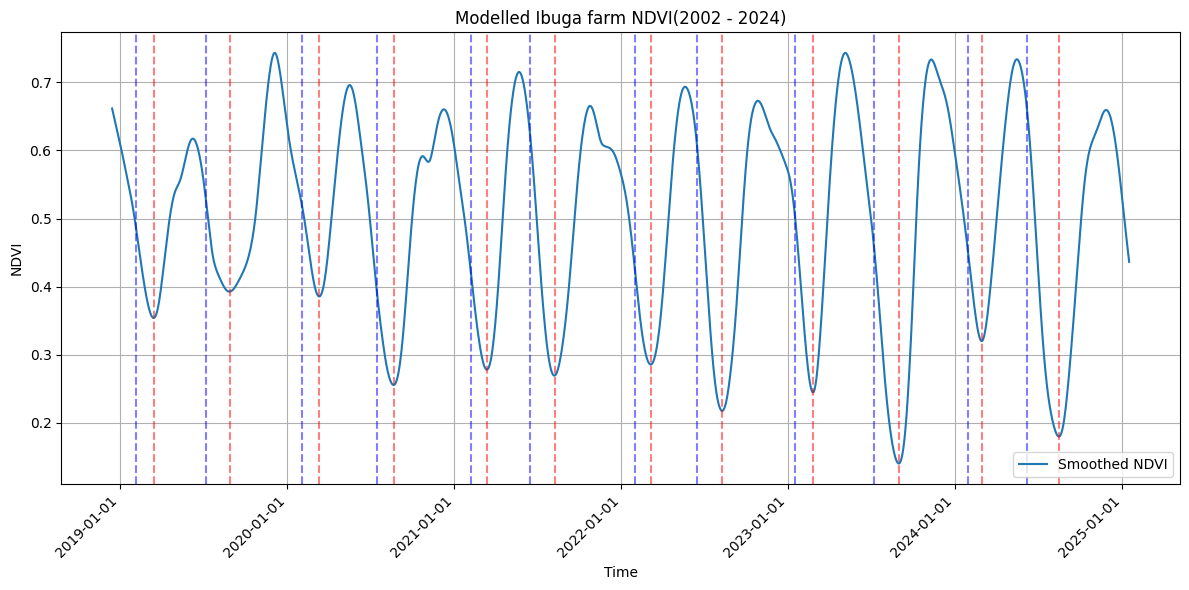

In [74]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the smoothed NDVI time series
plt.figure(figsize=(12, 6))
transformed_X.plot(label='Smoothed NDVI')


# Mark the dates from dates_see with vertical lines
# Need to get the corresponding NDVI values for dates_see from the smoothed data for plotting
# However, vlines is simpler to just mark the dates on the x-axis
#for date in dates_see.values:
  #  plt.axvline(date, color='red', linestyle='--', alpha=0.7) # Use axvline for vertical lines

# Mark the dates from dates_valley with vertical lines
for date in dates_valley.values:
    plt.axvline(date, color='blue', linestyle='--', alpha=0.5) # Use axvline for vertical lines

for date in dates_see .values:
    plt.axvline(date, color='red', linestyle='--', alpha=0.5) # Use axvline for vertical lines

plt.title('Modelled Ibuga farm NDVI(2002 - 2024)')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.grid(True)

# Optional: Improve x-axis formatting for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # More detailed date format
plt.xticks(rotation=45, ha='right') # Rotate date labels for readability

plt.legend()
plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [81]:
# Save the DataFrame as an HTML file
# Assuming 'season_lengths_df' is the DataFrame you want to save
html_output = season_lengths_df.to_html()

with open('season_lengths_method_2.html', 'w') as f:
    f.write(html_output)

print("DataFrame saved as season_lengths.html")

DataFrame saved as season_lengths.html


In [112]:
# Convert transformed_X to a pandas DataFrame
transformed_df = transformed_X.to_dataframe(name='NDVI').reset_index()

# Rename the time column to 'date' if needed, based on user's previous data
transformed_df = transformed_df.rename(columns={'time': 'date'})

print("Transformed data as a DataFrame:")
display(transformed_df.head())

Transformed data as a DataFrame:


,date,NDVI
0,2018-12-14,0.661584
1,2018-12-15,0.658613
2,2018-12-16,0.655644
3,2018-12-17,0.652679
4,2018-12-18,0.649719


Dont run befor

**------------------Phenology-------------------------**

**------------------Median_values-computation----------**

In [83]:
dates_see .values

array(['2019-03-15T00:00:00.000000000', '2019-08-28T00:00:00.000000000',
       '2020-03-11T00:00:00.000000000', '2020-08-21T00:00:00.000000000',
       '2021-03-13T00:00:00.000000000', '2021-08-08T00:00:00.000000000',
       '2022-03-06T00:00:00.000000000', '2022-08-10T00:00:00.000000000',
       '2023-02-24T00:00:00.000000000', '2023-08-31T00:00:00.000000000',
       '2024-02-28T00:00:00.000000000', '2024-08-15T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [103]:
# Organize troughs into consecutive pairs
trough_pairs = []
for i in range(len(end) - 1):
    start_date = end['time'].iloc[i]
    end_date = end['time'].iloc[i+1]

    # Calculate the duration between consecutive troughs
    duration = end_date - start_date

    # Append the pair and duration to the list
    trough_pairs.append({
        'trough_pair': f'Trough {i+1} to Trough {i+2}',
        'start_date': start_date,
        'end_date': end_date,
        'duration': duration
    })

# Create a DataFrame from the trough pairs
trough_pairs_df = pd.DataFrame(trough_pairs)

print("Consecutive Trough Pairs and Durations:")
display(trough_pairs_df)

Consecutive Trough Pairs and Durations:


,trough_pair,start_date,end_date,duration
0,Trough 1 to Trough 2,2019-03-15,2019-08-28,166 days
1,Trough 2 to Trough 3,2019-08-28,2020-03-11,196 days
2,Trough 3 to Trough 4,2020-03-11,2020-08-21,163 days
3,Trough 4 to Trough 5,2020-08-21,2021-03-13,204 days
4,Trough 5 to Trough 6,2021-03-13,2021-08-08,148 days
5,Trough 6 to Trough 7,2021-08-08,2022-03-06,210 days
6,Trough 7 to Trough 8,2022-03-06,2022-08-10,157 days
7,Trough 8 to Trough 9,2022-08-10,2023-02-24,198 days
8,Trough 9 to Trough 10,2023-02-24,2023-08-31,188 days
9,Trough 10 to Trough 11,2023-08-31,2024-02-28,181 days


In [107]:
# Get NDVI values at the start dates of the troughs
ndvi_at_start_dates = transformed_X.sel(time=trough_pairs_df['start_date'].tolist())

# Get NDVI values at the end dates of the troughs
ndvi_at_end_dates = transformed_X.sel(time=trough_pairs_df['end_date'].tolist())

print("NDVI values at the start dates of each trough pair:")
display(ndvi_at_start_dates)

print("\nNDVI values at the end dates of each trough pair:")
display(ndvi_at_end_dates)

NDVI values at the start dates of each trough pair:


<xarray.DataArray (time: 11)> Size: 88B
array([0.35400128, 0.39269301, 0.38551735, 0.25554314, 0.27807111,
       0.26935442, 0.28557914, 0.2174875 , 0.24466303, 0.14015657,
       0.3200883 ])
Coordinates:
  * time     (time) datetime64[ns] 88B 2019-03-15 2019-08-28 ... 2024-02-28


NDVI values at the end dates of each trough pair:


<xarray.DataArray (time: 11)> Size: 88B
array([0.39269301, 0.38551735, 0.25554314, 0.27807111, 0.26935442,
       0.28557914, 0.2174875 , 0.24466303, 0.14015657, 0.3200883 ,
       0.17984611])
Coordinates:
  * time     (time) datetime64[ns] 88B 2019-08-28 2020-03-11 ... 2024-08-15

In [108]:
# Get NDVI values at the start dates of the troughs
ndvi_at_start_dates = transformed_X.sel(time=trough_pairs_df['start_date'].tolist())

# Get NDVI values at the end dates of the troughs
ndvi_at_end_dates = transformed_X.sel(time=trough_pairs_df['end_date'].tolist())

print("NDVI values at the start dates of each trough pair:")
display(ndvi_at_start_dates)

print("\nNDVI values at the end dates of each trough pair:")
display(ndvi_at_end_dates)

NDVI values at the start dates of each trough pair:


<xarray.DataArray (time: 11)> Size: 88B
array([0.35400128, 0.39269301, 0.38551735, 0.25554314, 0.27807111,
       0.26935442, 0.28557914, 0.2174875 , 0.24466303, 0.14015657,
       0.3200883 ])
Coordinates:
  * time     (time) datetime64[ns] 88B 2019-03-15 2019-08-28 ... 2024-02-28


NDVI values at the end dates of each trough pair:


<xarray.DataArray (time: 11)> Size: 88B
array([0.39269301, 0.38551735, 0.25554314, 0.27807111, 0.26935442,
       0.28557914, 0.2174875 , 0.24466303, 0.14015657, 0.3200883 ,
       0.17984611])
Coordinates:
  * time     (time) datetime64[ns] 88B 2019-08-28 2020-03-11 ... 2024-08-15

In [142]:

# Compute the maximum NDVI for each pair
max_ndvi_per_pair = []
for index, row in trough_pairs_df.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']

    # Select the subset of transformed_X within the date range
    subset_transformed_X = transformed_X.sel(time=slice(start_date, end_date))

    # Compute the maximum NDVI in the subset
    max_ndvi = subset_transformed_X.max().values

    max_ndvi_per_pair.append(max_ndvi)

# Add the maximum NDVI values to the trough_pairs_df DataFrame
trough_pairs_df['max_ndvi'] = max_ndvi_per_pair

print("Consecutive Trough Pairs, Durations, NDVI Amplitude, and Maximum NDVI:")
display(trough_pairs_df)

Consecutive Trough Pairs, Durations, NDVI Amplitude, and Maximum NDVI:


,trough_pair,start_date,end_date,duration,eos_date,sos_date,max_ndvi,ndvi_at_start,ndvi_at_end,a_1,a_2,sos_v,eos_v
0,Trough 1 to Trough 2,2019-03-15,2019-08-28,166 days,2019-08-05,2019-04-05,0.6172831514053683,0.354001,0.392693,0.263282,0.22459,0.419822,0.415152
1,Trough 2 to Trough 3,2019-08-28,2020-03-11,196 days,2020-02-25,NaT,0.7433029441329366,0.392693,0.385517,0.35061,0.357786,0.480345,0.421296
2,Trough 3 to Trough 4,2020-03-11,2020-08-21,163 days,2020-08-02,NaT,0.6959751089633721,0.385517,0.255543,0.310458,0.440432,0.463132,0.299586
3,Trough 4 to Trough 5,2020-08-21,2021-03-13,204 days,2021-02-25,2020-09-14,0.6603704681183588,0.255543,0.278071,0.404827,0.382299,0.35675,0.316301
4,Trough 5 to Trough 6,2021-03-13,2021-08-08,148 days,2021-07-23,NaT,0.7152168160669342,0.278071,0.269354,0.437146,0.445862,0.387358,0.313941
5,Trough 6 to Trough 7,2021-08-08,2022-03-06,210 days,2022-02-18,2021-09-04,0.6653791224337038,0.269354,0.285579,0.396025,0.3798,0.368361,0.323559
6,Trough 7 to Trough 8,2022-03-06,2022-08-10,157 days,2022-07-25,NaT,0.6934317144946691,0.285579,0.217487,0.407853,0.475944,0.387542,0.265082
7,Trough 8 to Trough 9,2022-08-10,2023-02-24,198 days,2023-02-13,2022-09-06,0.6728651133618261,0.217487,0.244663,0.455378,0.428202,0.331332,0.287483
8,Trough 9 to Trough 10,2023-02-24,2023-08-31,188 days,2023-08-11,NaT,0.7432146014909475,0.244663,0.140157,0.498552,0.603058,0.369301,0.200462
9,Trough 10 to Trough 11,2023-08-31,2024-02-28,181 days,2024-02-15,2023-09-25,0.7335163799294931,0.140157,0.320088,0.59336,0.413428,0.288497,0.361431


In [143]:
# Extract NDVI values at the start dates
ndvi_at_start = transformed_X.sel(time=trough_pairs_df['start_date'].tolist()).values

# Extract NDVI values at the end dates
ndvi_at_end = transformed_X.sel(time=trough_pairs_df['end_date'].tolist()).values

# You can now use ndvi_at_start and ndvi_at_end for further analysis or display


trough_pairs_df['ndvi_at_start'] = ndvi_at_start

# Add the NDVI values at end dates to the trough_pairs_df
trough_pairs_df['ndvi_at_end'] = ndvi_at_end
trough_pairs_df['a_1'] = trough_pairs_df['max_ndvi'] - trough_pairs_df['ndvi_at_start']
trough_pairs_df['a_2'] = trough_pairs_df['max_ndvi'] - trough_pairs_df['ndvi_at_end']
trough_pairs_df['sos_v'] = trough_pairs_df['ndvi_at_start'] + (0.25)*trough_pairs_df['a_1']
trough_pairs_df['eos_v ']= trough_pairs_df['ndvi_at_end'] +  (0.1)*trough_pairs_df['a_2']

In [152]:
# Find the date when NDVI first crosses the sos_v for each trough pair
sos_crossing_dates = []

for index, row in trough_pairs_df.iterrows():
    start_date = row['start_date']
    sos_v_threshold = row['sos_v']

    # Select the subset of transformed_X starting from the start_date of the trough pair
    subset_transformed_X = transformed_X.sel(time=slice(start_date, None))

    # Find the index of the first date where NDVI is >= sos_v_threshold in the subset
    # Use argmax to find the first True value (where condition is met)
    # If no value meets the condition, argmax will return 0, so we need a check
    crossing_index_in_subset = np.argmax(subset_transformed_X.values >= sos_v_threshold)

    # Check if the threshold was actually crossed within the subset
    if subset_transformed_X.values[crossing_index_in_subset] >= sos_v_threshold:
        sos_date = subset_transformed_X['time'].values[crossing_index_in_subset]
        sos_crossing_dates.append(sos_date)
    else:
        # If the threshold is not crossed in the remaining data, append NaT
        sos_crossing_dates.append(pd.NaT)

trough_pairs_df['start_1'] = sos_crossing_dates


In [153]:
# Find the date when NDVI first crosses the eos_v for each trough pair
eos_crossing_dates = []

for index, row in trough_pairs_df.iterrows():
    start_date = row['start_date']
    end_date = row['end_date']
    eos_v_threshold = row['eos_v '] # Note the space in 'eos_v '

    # Select the subset of transformed_X within the date range of the trough pair
    subset_transformed_X = transformed_X.sel(time=slice(start_date, end_date))

    # Find the index of the maximum NDVI (peak) in the subset to define the start of senescence
    peak_index_in_subset = subset_transformed_X.argmax(dim='time').values

    # Select the senescence phase data (from the peak to the end of the subset)
    senescence_phase_data = subset_transformed_X.isel(time=slice(peak_index_in_subset, None))


    # Find the index of the first date where NDVI is <= eos_v_threshold in the senescence phase
    # Use argmin to find the first True value where the condition is met
    # If no value meets the condition, argmin will return 0, so we need a check
    crossing_index_in_senescence = np.argmax(senescence_phase_data.values <= eos_v_threshold)


    # Check if the threshold was actually crossed within the senescence phase
    # Need to handle the case where argmax returns 0 but the first value is not <= threshold
    if senescence_phase_data.values[crossing_index_in_senescence] <= eos_v_threshold:
         eos_date = senescence_phase_data['time'].values[crossing_index_in_senescence]
         eos_crossing_dates.append(eos_date)
    else:
        # If the threshold is not crossed in the senescence phase, append NaT
        eos_crossing_dates.append(pd.NaT)
trough_pairs_df['end_1'] = eos_crossing_dates


In [159]:
length_of_seasons = trough_pairs_df['sos_date']

In [161]:
# Compute the length of the season using 'start_1' and 'end_1'
trough_pairs_df['length_1'] = trough_pairs_df['end_1'] - trough_pairs_df['start_1']



In [163]:
trough_pairs_df


,trough_pair,start_date,end_date,duration,eos_date,sos_date,max_ndvi,ndvi_at_start,ndvi_at_end,a_1,a_2,sos_v,eos_v,start_1,end_1,length_1
0,Trough 1 to Trough 2,2019-03-15,2019-08-28,166 days,2019-08-05,2019-04-05,0.6172831514053683,0.354001,0.392693,0.263282,0.22459,0.419822,0.415152,2019-04-05,2019-08-05,122 days
1,Trough 2 to Trough 3,2019-08-28,2020-03-11,196 days,2020-02-25,NaT,0.7433029441329366,0.392693,0.385517,0.35061,0.357786,0.480345,0.421296,2019-10-20,2020-02-25,128 days
2,Trough 3 to Trough 4,2020-03-11,2020-08-21,163 days,2020-08-02,NaT,0.6959751089633721,0.385517,0.255543,0.310458,0.440432,0.463132,0.299586,2020-04-02,2020-08-02,122 days
3,Trough 4 to Trough 5,2020-08-21,2021-03-13,204 days,2021-02-25,2020-09-14,0.6603704681183588,0.255543,0.278071,0.404827,0.382299,0.35675,0.316301,2020-09-14,2021-02-25,164 days
4,Trough 5 to Trough 6,2021-03-13,2021-08-08,148 days,2021-07-23,NaT,0.7152168160669342,0.278071,0.269354,0.437146,0.445862,0.387358,0.313941,2021-04-06,2021-07-23,108 days
5,Trough 6 to Trough 7,2021-08-08,2022-03-06,210 days,2022-02-18,2021-09-04,0.6653791224337038,0.269354,0.285579,0.396025,0.3798,0.368361,0.323559,2021-09-04,2022-02-18,167 days
6,Trough 7 to Trough 8,2022-03-06,2022-08-10,157 days,2022-07-25,NaT,0.6934317144946691,0.285579,0.217487,0.407853,0.475944,0.387542,0.265082,2022-04-02,2022-07-25,114 days
7,Trough 8 to Trough 9,2022-08-10,2023-02-24,198 days,2023-02-13,2022-09-06,0.6728651133618261,0.217487,0.244663,0.455378,0.428202,0.331332,0.287483,2022-09-06,2023-02-13,160 days
8,Trough 9 to Trough 10,2023-02-24,2023-08-31,188 days,2023-08-11,NaT,0.7432146014909475,0.244663,0.140157,0.498552,0.603058,0.369301,0.200462,2023-03-17,2023-08-11,147 days
9,Trough 10 to Trough 11,2023-08-31,2024-02-28,181 days,2024-02-15,2023-09-25,0.7335163799294931,0.140157,0.320088,0.59336,0.413428,0.288497,0.361431,2023-09-25,2024-02-15,143 days


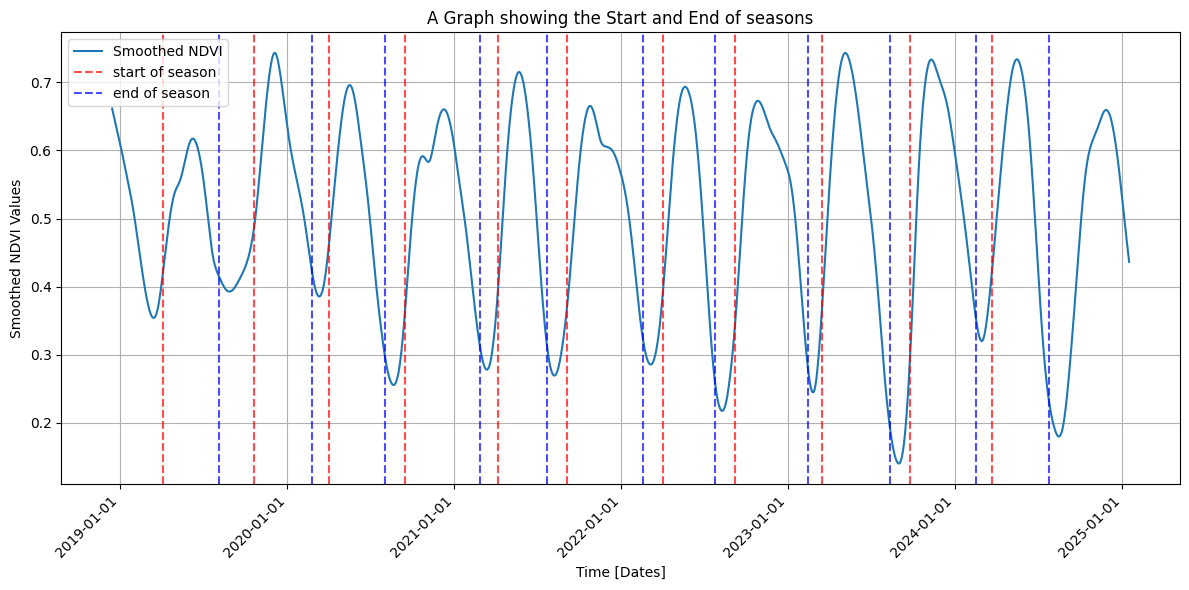

In [166]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot the smoothed NDVI time series
plt.figure(figsize=(12, 6))
transformed_X.plot(label='Smoothed NDVI')

# Mark the start_1 dates with vertical lines
for date in trough_pairs_df['start_1'].dropna():
    plt.axvline(date, color='red', linestyle='--', alpha=0.7, label='start of season' if date == trough_pairs_df['start_1'].dropna().iloc[0] else "")

# Mark the end_1 dates with vertical lines
for date in trough_pairs_df['end_1'].dropna():
    plt.axvline(date, color='blue', linestyle='--', alpha=0.7, label='end of season' if date == trough_pairs_df['end_1'].dropna().iloc[0] else "")

plt.title('A Graph showing the Start and End of seasons')
plt.xlabel('Time [Dates]')
plt.ylabel('Smoothed NDVI Values')
plt.grid(True)

# Optional: Improve x-axis formatting for dates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # More detailed date format
plt.xticks(rotation=45, ha='right') # Rotate date labels for readability

# Add a single legend entry for start_1 and end_1
handles, labels = ax.get_legend_handles_labels()
# Assuming Smoothed NDVI is first, start_1 is second, end_1 is third based on adding order
new_handles = [handles[i] for i in [0, 1, 2]]
new_labels = [labels[i] for i in [0, 1, 2]]
ax.legend(new_handles, new_labels)


plt.tight_layout() # Adjust layout to prevent labels overlapping
plt.show()

In [167]:
# Create a new DataFrame to store the recomputed phenological parameters
recomputed_pheno_df = pd.DataFrame(columns=['SOS', 'POS', 'EOS', 'vSOS', 'vPOS', 'vEOS', 'Trough', 'LOS', 'AOS', 'ROG', 'ROS'])

for index, row in trough_pairs_df.iterrows():
    sos_date = row['start_1']
    eos_date = row['end_1']
    start_date_trough_pair = row['start_date'] # Use original trough pair start and end for subsetting
    end_date_trough_pair = row['end_date']

    # Only compute if both SOS and EOS dates are available
    if pd.notna(sos_date) and pd.notna(eos_date):
        # Select the subset of transformed_X within the date range of the trough pair
        subset_transformed_X = transformed_X.sel(time=slice(start_date_trough_pair, end_date_trough_pair))

        # Compute Trough value within the trough pair range
        trough_value = subset_transformed_X.min().values

        # Find the peak of the season (POS) and its value (vPOS) within the SOS and EOS dates
        subset_season_X = transformed_X.sel(time=slice(sos_date, eos_date))
        if len(subset_season_X) > 0:
            peak_index_in_season = subset_season_X.argmax(dim='time').values
            pos_date = subset_season_X['time'].isel(time=peak_index_in_season).values
            vpos_value = subset_season_X.isel(time=peak_index_in_season).values
        else:
            pos_date = pd.NaT
            vpos_value = np.nan


        # Get vSOS and vEOS values from the transformed_X data
        v_sos_value = transformed_X.sel(time=sos_date).values
        v_eos_value = transformed_X.sel(time=eos_date).values

        # Compute Length of Season (LOS)
        los = (pd.to_datetime(eos_date) - pd.to_datetime(sos_date)).days

        # Compute Amplitude of Season (AOS) - using vPOS and vSOS
        aos = vpos_value - v_sos_value if pd.notna(vpos_value) and pd.notna(v_sos_value) else np.nan

        # Compute Rate of Greening (ROG)
        # ROG = (vPOS - vSOS) / (POS - SOS)
        rog = (vpos_value - v_sos_value) / (pd.to_datetime(pos_date) - pd.to_datetime(sos_date)).days if pd.notna(vpos_value) and pd.notna(v_sos_value) and pd.notna(pos_date) and pd.notna(sos_date) and (pd.to_datetime(pos_date) - pd.to_datetime(sos_date)).days != 0 else np.nan

        # Compute Rate of Senescence (ROS)
        # ROS = (vPOS - vEOS) / (EOS - POS)
        ros = (vpos_value - v_eos_value) / (pd.to_datetime(eos_date) - pd.to_datetime(pos_date)).days if pd.notna(vpos_value) and pd.notna(v_eos_value) and pd.notna(eos_date) and pd.notna(pos_date) and (pd.to_datetime(eos_date) - pd.to_datetime(pos_date)).days != 0 else np.nan

        # Append the computed parameters to the DataFrame
        recomputed_pheno_df = pd.concat([recomputed_pheno_df, pd.DataFrame([{
            'SOS': sos_date,
            'POS': pos_date,
            'EOS': eos_date,
            'vSOS': v_sos_value,
            'vPOS': vpos_value,
            'vEOS': v_eos_value,
            'Trough': trough_value,
            'LOS': los,
            'AOS': aos,
            'ROG': rog,
            'ROS': ros
        }])], ignore_index=True)

print("Recomputed Phenological Parameters per Season (based on start_1 and end_1):")
display(recomputed_pheno_df)

# Export the DataFrame to an HTML file
html_output = recomputed_pheno_df.to_html()
with open('recomputed_phenological_parameters.html', 'w') as f:
    f.write(html_output)

print("\nRecomputed phenological parameters saved as recomputed_phenological_parameters.html")

Recomputed Phenological Parameters per Season (based on start_1 and end_1):


/tmp/ipython-input-1168807961.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  recomputed_pheno_df = pd.concat([recomputed_pheno_df, pd.DataFrame([{


,SOS,POS,EOS,vSOS,vPOS,vEOS,Trough,LOS,AOS,ROG,ROS
0,2019-04-05,2019-06-09,2019-08-05,0.4254201259380515,0.6172831514053683,0.4146172513586058,0.3540012789053929,122,0.191863,0.002952,0.003556
1,2019-10-20,2019-12-05,2020-02-25,0.48405211458789543,0.7433029441329366,0.41862507422862305,0.3855173512064908,128,0.259251,0.005636,0.003959
2,2020-04-02,2020-05-17,2020-08-02,0.46654563296819673,0.6959751089633721,0.2970294311309122,0.25554314458657246,122,0.229429,0.005098,0.005181
3,2020-09-14,2020-12-09,2021-02-25,0.35710760022907306,0.6603704681183588,0.31515457552591775,0.25554314458657246,164,0.303263,0.003526,0.004426
4,2021-04-06,2021-05-22,2021-07-23,0.3939327704059929,0.7152168160669342,0.3098706890432336,0.26935442428672396,108,0.321284,0.006984,0.006538
5,2021-09-04,2021-10-25,2022-02-18,0.3685159124987236,0.6653791224337038,0.31978895577635613,0.26935442428672396,167,0.296863,0.005821,0.002979
6,2022-04-02,2022-05-20,2022-07-25,0.3921948121403442,0.6934317144946691,0.25928076924182597,0.21748749946555437,114,0.301237,0.006276,0.006578
7,2022-09-06,2022-10-27,2023-02-13,0.337502942254994,0.6728651133618261,0.2817468621671656,0.21748749946555437,160,0.335362,0.006576,0.003588
8,2023-03-17,2023-05-06,2023-08-11,0.378173408203051,0.7432146014909475,0.19610407306079347,0.14015656560383716,147,0.365041,0.007301,0.005640
9,2023-09-25,2023-11-10,2024-02-15,0.30091390425404063,0.7335163799294931,0.35712063088737944,0.14015656560383716,143,0.432602,0.009404,0.003880



Recomputed phenological parameters saved as recomputed_phenological_parameters.html
